In [ ]:
# Copyright Elasticsearch B.V. and/or licensed to Elasticsearch B.V. under one
# or more contributor license agreements. Licensed under the Elastic License;
# you may not use this file except in compliance with the Elastic License.

# Scenario 1: Data summarization

1. Train model (M1) on the complete dataset (D1)

2. Generate a summarization dataset using some technique (D2)

3. Train a new model (M2) on D2
    1. Use the same best hyperparameters as for M1   
    2. **Identify a new set of best hyperparameters**
    
4. Compare M1 and M2
    1. Evaluation M1 and M2 on the complete dataset D1.
    2. Evaluate M1 and M2 on a grid and compute divergence
    3. Compare feature importance vectors for individual data points from M1 and M2 (should be very similar)
    4. Compare errors on the test dataset (D3)

**Notes:**
- We assume that generation of a summarization dataset is implemented. It can be written in Python for prototyping.
- 4 can be done with an inference pipeline and eland
- We need a simple way to query a model using inference pipeline (e.g. Python wrapper?)
- Evaluations can also be done with sklearn?
- What is the minimum amount of data we can get away with?


In [5]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import json
import tempfile
import platform
import time
import string
import random

import pandas as pd
import numpy as np
import diversipy
import libtmux 

from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error

import sys
from incremental_learning.misc import train, summarize, update, evaluate
from incremental_learning.config import datasets_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Train model (M1) on the complete dataset (D1)

In [13]:
datasets_dir.exists()

False

In [11]:
dataset_name = 'ccpp'
D1 = pd.read_csv((datasets_dir / '{}.csv'.format(dataset_name)).absolute())
D1.drop_duplicates(inplace=True)

job1 = train(dataset_name, D1)

FileNotFoundError: [Errno 2] No such file or directory: '/home/valeriy/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/evaluation_scenarios/data/datasets/ccpp.csv'

In [15]:
job1.wait_to_complete()

stderr,output
"/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpnby046oh --config /tmp/tmpdu9wgqmf --output /tmp/tmp6cy5j2rq --persist /tmp/tmp53kqctv1; if [ $? -eq 0 ]; then echo ""Success""; else echo ""Failure""; fi (env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/evaluation_scenarios [feature/incremental-learning|✚ 4…1⚑ 6] 14:13 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpnby046oh --config /tmp/tmpdu9wgqmf --output /tmp/tmp6cy5j2rq --persist /tmp/tmp53kqctv1; if [ $? -eq 0 ]; then echo ""Success""; else echo ""Failure""; fi 2021-06-23 12:13:54,122734 UTC [21984] DEBUG Main.cc@145 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV 2021-06-23 12:13:54,123068 UTC [21984] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj 2021-06-23 12:13:54,123084 UTC [21984] DEBUG CSystemCallFilter_Linux.cc@128 Seccomp BPF filters available 2021-06-23 12:13:54,123528 UTC [21984] DEBUG CSystemCallFilter_Linux.cc@154 Seccomp BPF installed 2021-06-23 12:13:54,324347 UTC [21984] DEBUG CDataFrameAnalyzer.cc@102 Received 19949 rows 2021-06-23 12:24:47,919591 UTC [21984] INFO CBoostedTreeImpl.cc@260 Exiting hyperparameter optimisation loop early 2021-06-23 12:25:02,610466 UTC [21984] INFO Main.cc@248 [{""name"":""E_DFTPMEstimatedPeakMemoryUsage"",""description"":""The upfront estimate of the peak memory training the predictive model would use"",""value"":99508686} ,{""name"":""E_DFTPMPeakMemoryUsage"",""description"":""The peak memory training the predictive model used"",""value"":21679340} ,{""name"":""E_DFTPMTimeToTrain"",""description"":""The time it took to train the predictive model"",""value"":667391} ,{""name"":""E_DFTPMTrainedForestNumberTrees"",""description"":""The total number of trees in the trained forest"",""value"":214} ] 2021-06-23 12:25:02,610585 UTC [21984] DEBUG Main.cc@253 ML data frame analyzer exiting Success (env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/evaluation_scenarios [feature/incremental-learning|✚ 4…1⚑ 6] 14:25 $",",{""row_results"":{""checksum"":0,""results"":{""ml"":{""malicious_prediction"":""1"",""predi ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""malicious_prediction"":""1"",""predi ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""malicious_prediction"":""1"",""predi ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""malicious_prediction"":""1"",""predi ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""malicious_prediction"":""1"",""predi ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""malicious_prediction"":""1"",""predi ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""malicious_prediction"":""1"",""predi ,{""model_metadata"":{""total_feature_importance"":[],""hyperparameters"":[{""name"":""do ,{""compressed_data_summarization"":{""doc_num"":0,""data_summarization"":""H4sIAAAAAAA ]"


 /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpnby046oh --config /tmp/tmpdu9wgqmf --output /tmp/tmp6cy5j2rq --persist /tmp/tmp53kqctv1; if [ $? -eq 0 ]; then echo "Success"; else echo "Failure";  fi
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/evaluation_scenarios [feature/incremental-learning|✚ 4…1⚑ 6]
14:13 $  /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpnby046oh --config /tmp/tmpdu9wgqmf --output /tmp/tmp6cy5j2rq --persist /tmp/tmp53kqctv1; if [ $? -eq 0 ]; then echo "Success"; else echo "Failure";  fi
2021-06-23 12:13:54,122734 UTC [21984] DEBUG Main.cc@145 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV
2021-06-23 12:13:54,123068 UTC [21984] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM kil

True

## 2. Generate a sumarization dataset

In [16]:
sampling_method = 'random'
D2 = summarize(dataset_name=dataset_name, dataset=D1,
              size=0.25, model_definition=job1.get_model_definition(), 
              method=sampling_method, verbose=False, 
              dependent_variable=job1.dependent_variable)

## 3. A. Train a new model with the same best best hyperparameters

In [ ]:
# TODO I need to inject hyperparameters here
job2 = train(dataset_name, D2)

In [5]:
job2.wait_to_complete()

stderr,output
"/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpm_kat7j5 --config /tmp/tmpfid63qs_ --output /tmp/tmpspypjc8c --persist /tmp/tmpwsdubizi (env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/evaluation_scenarios [feature/incremental-learning L|✚ 6…4⚑ 3] 13:04 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpm_kat7j5 --config /tmp/tmpfid63qs_ --output /tmp/tmpspypjc8c --persist /tmp/tmpwsdubizi 2021-04-21 11:04:22,377843 UTC [16324] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV 2021-04-21 11:04:22,377923 UTC [16324] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj 2021-04-21 11:04:22,377936 UTC [16324] DEBUG CSystemCallFilter_Linux.cc@128 Seccomp BPF filters available 2021-04-21 11:04:22,379466 UTC [16324] DEBUG CSystemCallFilter_Linux.cc@154 Seccomp BPF installed 2021-04-21 11:04:22,387888 UTC [16324] DEBUG CDataFrameAnalyzer.cc@104 Received 1500 rows 2021-04-21 11:05:00,028969 UTC [16324] INFO CBoostedTreeImpl.cc@240 Exiting hyperparameter optimisation loop early 2021-04-21 11:05:00,290295 UTC [16324] INFO Main.cc@241 [{""name"":""E_DFTPMEstimatedPeakMemoryUsage"",""description"":""The upfront estimate of the peak memory training the predictive model would use"",""value"":25849781} ,{""name"":""E_DFTPMPeakMemoryUsage"",""description"":""The peak memory training the predictive model used"",""value"":7919095} ,{""name"":""E_DFTPMTimeToTrain"",""description"":""The time it took to train the predictive model"",""value"":37789} ,{""name"":""E_DFTPMTrainedForestNumberTrees"",""description"":""The total number of trees in the trained forest"",""value"":86} ] 2021-04-21 11:05:00,290330 UTC [16324] DEBUG Main.cc@246 ML data frame analyzer exiting (env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/evaluation_scenarios [feature/incremental-learning L|✚ 6…4⚑ 3] 13:05 $",",{""row_results"":{""checksum"":0,""results"":{""ml"":{""54_prediction"":124.1134567260742 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""54_prediction"":1.505854725837707 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""54_prediction"":2.995656013488769 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""54_prediction"":12.00612449645996 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""54_prediction"":1.447953820228576 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""54_prediction"":14.12492275238037 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""54_prediction"":0.421843171119689 ,{""model_metadata"":{""total_feature_importance"":[],""hyperparameters"":[{""name"":""do ,{""compressed_data_summarization"":{""doc_num"":0,""data_summarization"":""H4sIAAAAAAA ]"


 /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpm_kat7j5 --config /tmp/tmpfid63qs_ --output /tmp/tmpspypjc8c --persist /tmp/tmpwsdubizi
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/evaluation_scenarios [feature/incremental-learning L|✚ 6…4⚑ 3]
13:04 $  /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpm_kat7j5 --config /tmp/tmpfid63qs_ --output /tmp/tmpspypjc8c --persist /tmp/tmpwsdubizi
2021-04-21 11:04:22,377843 UTC [16324] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV
2021-04-21 11:04:22,377923 UTC [16324] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-04-21 11:04:22,377936 UTC [16324] DEBUG CSystemCallFilter_Linux.cc@128 Seccom

True

## 3. B. Train a new model with new best hyperparameters

In [ ]:
job2 = train(dataset_name, D2)

In [14]:
job2.wait_to_complete()

session: job_xbmzv	command:
/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpteocz31h --config /tmp/tmp2od10o5o --output /tmp/tmp6q1fs68x --persist model2.json


## 3. C. Incremetally train a new model

In [17]:
job2 = update(dataset_name, D2, job1)

session: job_wreac	command:
/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpxpiku7ka --config /tmp/tmp8004m702 --output /tmp/tmp7uehxmox --restore /tmp/tmpkp4ts3ir; if [ $? -eq 0 ]; then echo "Success"; else echo "Failure";  fi;


In [18]:
job2.wait_to_complete()

stderr 
 output 
 
 
 2021-06-23 12:30:34,146876 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146881 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146884 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146889 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146893 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146898 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146907 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146903 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146913 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146918 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146923 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146927 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146932 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146937 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146942 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146947 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146952 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146955 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146957 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146961 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146966 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146970 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146973 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146976 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146981 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146985 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146990 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146996 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146999 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147003 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147008 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147013 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147019 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147022 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147024 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147034 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147039 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147043 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147045 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147050 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147055 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147059 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147065 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,147069 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:3

2021-06-23 12:30:34,146876 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146881 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146884 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146889 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146893 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146898 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146907 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146903 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146913 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146918 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23 12:30:34,146923 UTC [23268] DEBUG CDataFrameUtils.cc@1079 Wrong actual class 3
2021-06-23

True

## 4. A. Compare M1 and M2 on D1

In [7]:
y_true = D1[job1.dependent_variable]
y_M1 = job1.get_predictions()
eval_job = evaluate(dataset_name=dataset_name,
                            dataset=D1, model=job2.model, verbose=False)
success = eval_job.wait_to_complete()
if not success:
    print('Evaluation failed')
y_M2 = eval_job.get_predictions()

In [8]:
def compute_metrics(ytrue, m1pred, m2pred):
    m1_mae = mean_absolute_error(ytrue, m1pred)
    m1_mse = mean_squared_error(ytrue, m1pred)
    m2_mae = mean_absolute_error(ytrue, m2pred)
    m2_mse = mean_squared_error(ytrue, m2pred)
    print("M1: MAE: {}\tMSE:{}".format(m1_mae, m1_mse))
    print("M2: MAE: {}\tMSE:{}".format(m2_mae, m2_mse))
    ax = sns.scatterplot(x=m1pred, y=m2pred)
    plt.xlabel('M1 predictions')
    plt.ylabel('M2 predictions')

M1: MAE: 2.9948999743493427	MSE:81.21282728062585
M2: MAE: 4.747365797487398	MSE:468.8721068394406


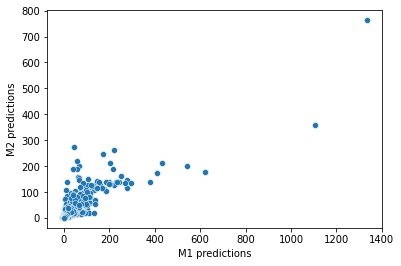

In [9]:
compute_metrics(y_true, y_M1, y_M2)